## Import the dependencies

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import joblib
%matplotlib inline

In [2]:
# Fetching coca cola stocks 
ticker = 'KO' # coca cola stock ticker
df=yf.download(ticker,start='2015-01-01',end='2024-12-31')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
df.reset_index(inplace=True)

In [4]:
df.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,KO,KO,KO,KO,KO
0,2015-01-02,30.222607,30.409079,29.978760,30.308669,9921100
1,2015-01-05,30.222607,30.817880,30.179577,30.617063,26292600
2,2015-01-06,30.452110,30.796364,30.294329,30.416251,16897500
3,2015-01-07,30.832241,30.918304,30.538191,30.695972,13412300
4,2015-01-08,31.205173,31.248206,30.911123,30.968500,21743600


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2515 entries, 0 to 2514
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   (Date, )      2515 non-null   datetime64[ns]
 1   (Close, KO)   2515 non-null   float64       
 2   (High, KO)    2515 non-null   float64       
 3   (Low, KO)     2515 non-null   float64       
 4   (Open, KO)    2515 non-null   float64       
 5   (Volume, KO)  2515 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 118.0 KB


In [6]:
df.columns=df.columns.get_level_values(0)

In [7]:
df

Price,Date,Close,High,Low,Open,Volume
0,2015-01-02,30.222607,30.409079,29.978760,30.308669,9921100
1,2015-01-05,30.222607,30.817880,30.179577,30.617063,26292600
2,2015-01-06,30.452110,30.796364,30.294329,30.416251,16897500
3,2015-01-07,30.832241,30.918304,30.538191,30.695972,13412300
4,2015-01-08,31.205173,31.248206,30.911123,30.968500,21743600
...,...,...,...,...,...,...
2510,2024-12-23,61.485874,61.860425,60.648055,61.604153,13010800
2511,2024-12-24,61.939281,61.939281,61.121176,61.308456,5019100
2512,2024-12-26,61.673149,61.840714,61.505588,61.722432,7943800
2513,2024-12-27,61.554871,62.047704,61.318309,61.554871,8542800


In [8]:
df['Date']=pd.to_datetime(df['Date'])

In [9]:
df.set_index('Date',inplace=True)

In [10]:
df.columns=df.columns.get_level_values(0)

In [11]:
df.shape

(2515, 5)

In [12]:
df.isnull().sum()

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,30.222607,30.409079,29.978760,30.308669,9921100
2015-01-05,30.222607,30.817880,30.179577,30.617063,26292600
2015-01-06,30.452110,30.796364,30.294329,30.416251,16897500
2015-01-07,30.832241,30.918304,30.538191,30.695972,13412300
2015-01-08,31.205173,31.248206,30.911123,30.968500,21743600


## Feature Engineering

In [15]:
# Adding moving averages for 20 and 50 days
df['MA_20']=df['Close'].rolling(window=20).mean()
df['MA_50']=df['Close'].rolling(window=50).mean()

In [16]:
# Adding moving avg crossover
df['MA_Cross'] = df['MA_20'] - df['MA_50']

In [17]:
# Adding Daily returns
df['Daily_Return'] = df['Close'].pct_change().shift(1)

In [18]:
# adding volatility
df['Volatility']=df['Daily_Return'].rolling(window=20).std().shift(1)

In [19]:
df.dropna(inplace=True)

In [20]:
df.describe()

Price,Close,High,Low,Open,Volume,MA_20,MA_50,MA_Cross,Daily_Return,Volatility
count,2466.000000,2466.000000,2466.000000,2466.000000,2.466000e+03,2466.000000,2466.000000,2466.000000,2466.000000,2466.000000
mean,44.373534,44.672251,44.065152,44.374848,1.409691e+07,44.250553,44.055375,0.195177,0.000364,0.009773
std,10.808079,10.882200,10.721701,10.807684,6.164781e+06,10.753994,10.662247,1.144334,0.011221,0.005640
min,27.698986,28.086044,26.656349,27.698980,2.996300e+06,28.357795,29.164707,-6.752815,-0.096725,0.003597
25%,34.788731,35.005341,34.581957,34.762773,1.028500e+07,34.715509,34.484514,-0.274978,-0.004560,0.006739
50%,42.857714,43.260179,42.540098,42.858892,1.281230e+07,42.978647,42.735207,0.237499,0.000643,0.008544
75%,55.110232,55.543607,54.677563,55.127740,1.597515e+07,54.978029,54.749515,0.867211,0.005753,0.010817
max,70.935493,71.440708,70.197086,71.217247,6.784570e+07,69.880131,68.925591,2.975704,0.064796,0.053882


## EDA

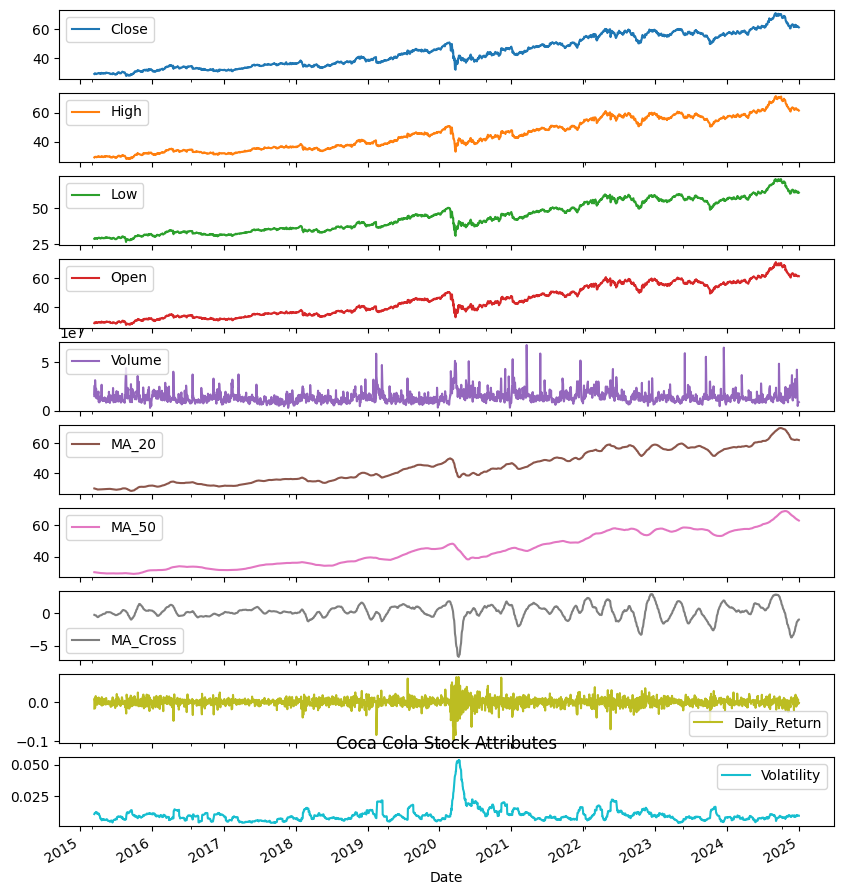

In [21]:
df.plot(subplots=True,figsize=(10,12))
plt.title('Coca Cola Stock Attributes')
plt.show()

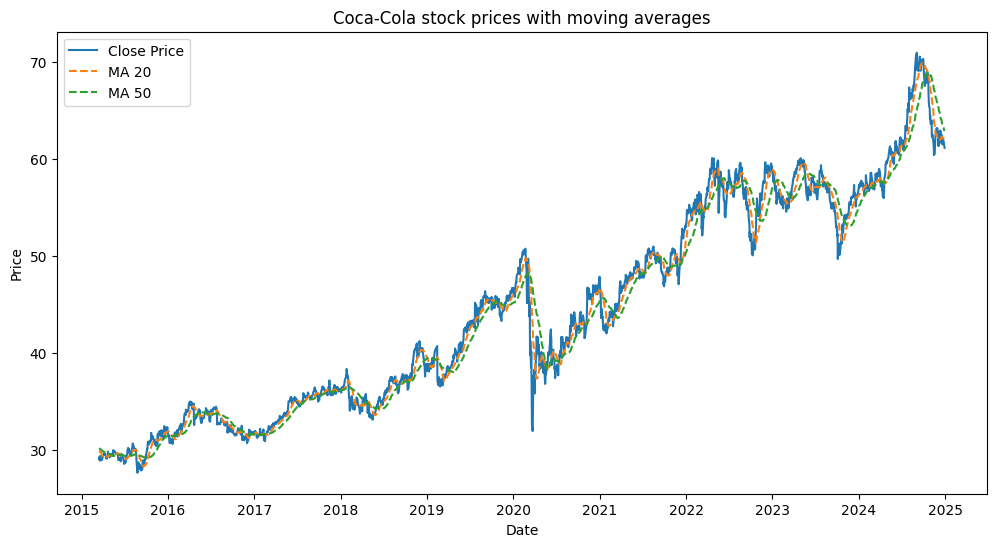

In [22]:
plt.figure(figsize=(12,6))
plt.plot(df.index,df['Close'],label='Close Price')
plt.plot(df.index,df['MA_20'],label='MA 20',linestyle='--')
plt.plot(df.index,df['MA_50'],label='MA 50',linestyle='--')
plt.title('Coca-Cola stock prices with moving averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

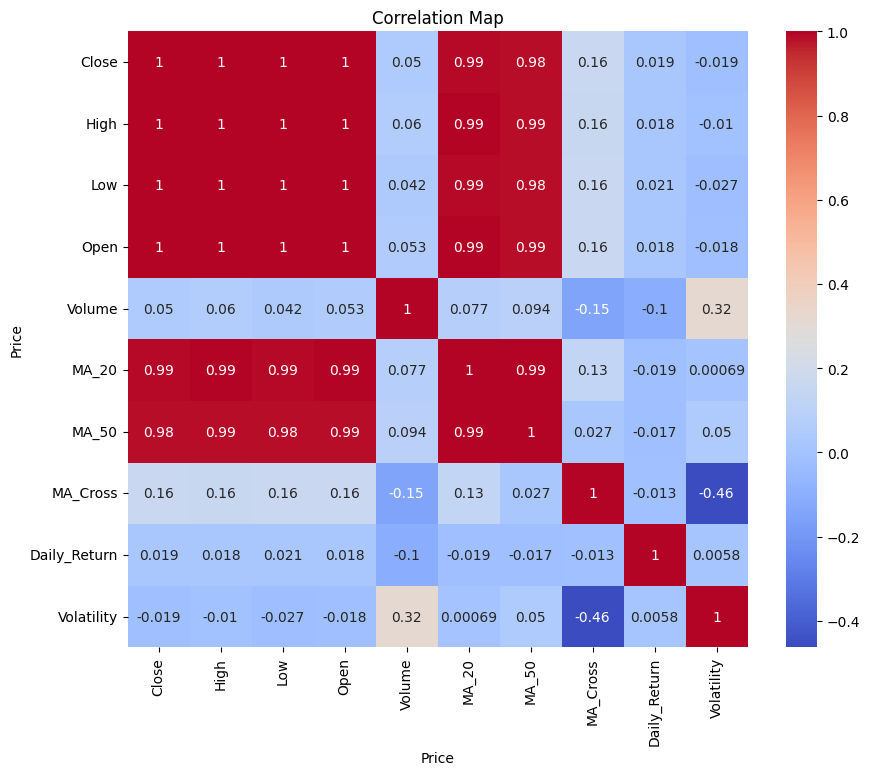

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation Map')
plt.show()

## Splitting the data

In [24]:
X=df.drop(['Close'],axis='columns')
y=df['Close']

In [25]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,shuffle=False)

In [26]:
X.reset_index(drop=True,inplace=True)

In [27]:
X_train

Price,High,Low,Open,Volume,MA_20,MA_50,MA_Cross,Daily_Return,Volatility
Date,,,,,,,,,
2015-03-16,29.178958,28.918627,28.925857,15238800,29.976335,30.228814,-0.252480,-0.016268,0.010606
2015-03-17,29.453759,29.157269,29.410370,21661800,29.941771,30.210256,-0.268484,0.009521,0.011082
2015-03-18,29.497152,28.781236,29.272976,26247500,29.913331,30.192999,-0.279668,0.005461,0.011377
2015-03-19,29.301896,28.896933,29.272970,16057600,29.850291,30.162763,-0.312471,0.002222,0.011464
2015-03-20,29.403135,28.933088,28.976478,31608500,29.815052,30.134036,-0.318984,-0.014286,0.011486
...,...,...,...,...,...,...,...,...,...
2023-01-05,58.228298,57.560715,58.042857,9814700,58.798528,57.300915,1.497612,-0.000477,0.008489
2023-01-06,59.034960,58.024313,58.330288,9990000,58.792037,57.391134,1.400903,-0.011443,0.007953
2023-01-09,59.081331,58.024321,58.691904,9442600,58.736405,57.458602,1.277803,0.019293,0.008327


## Model Training

In [28]:
scaler=MinMaxScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [29]:
model=RandomForestRegressor(n_estimators=300,random_state=42,n_jobs=-1)
model.fit(X_train_scaled,y_train)

RandomForestRegressor(n_estimators=300, n_jobs=-1, random_state=42)

In [30]:
y_pred=model.predict(X_test_scaled)

In [31]:
mse=mean_squared_error(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)

In [32]:
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 11.125107756546372
Mean Absolute Error: 1.6760853906906892


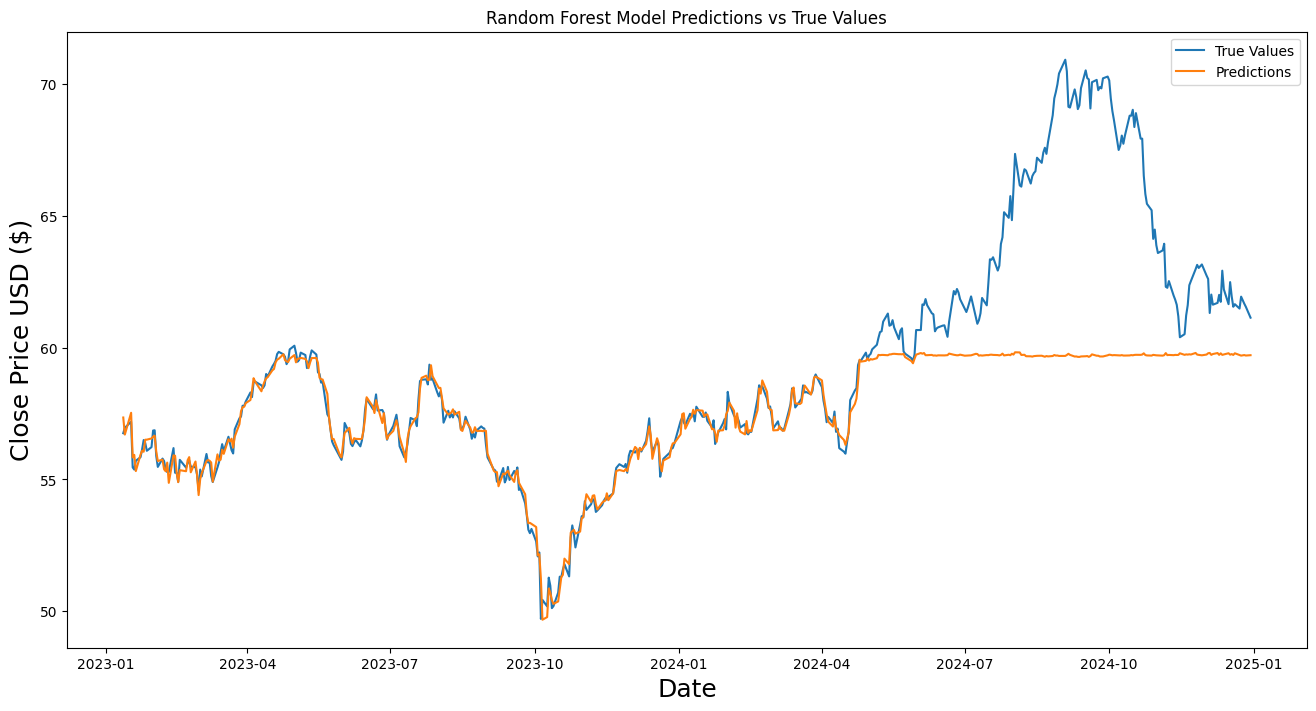

In [33]:
plt.figure(figsize=(16,8))
plt.title('Random Forest Model Predictions vs True Values')
plt.plot(y_test.index, y_test, label='True Values')
plt.plot(y_test.index, y_pred, label='Predictions')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.legend()
plt.show()

## Predicting Live Data

In [34]:
# Fetch latest stock data
live_data=yf.download(ticker,period='1d',interval='1m')

[*********************100%***********************]  1 of 1 completed


In [35]:
# Adding moving averages for 20 and 50 days
live_data['MA_20']=live_data['Close'].rolling(window=20).mean()
live_data['MA_50']=live_data['Close'].rolling(window=50).mean()

In [36]:
# Adding moving avg crossover
live_data['MA_Cross'] = live_data['MA_20'] - live_data['MA_50']

In [37]:
# Adding Daily returns
live_data['Daily_Return'] = live_data['Close'].pct_change()

In [38]:
# adding volatility
live_data['Volatility']=live_data['Daily_Return'].rolling(window=20).std()

In [39]:
live_data.fillna(0,inplace=True)

In [40]:
live_data.columns=live_data.columns.get_level_values(0)

In [41]:
live_data

Price,Close,High,Low,Open,Volume,MA_20,MA_50,MA_Cross,Daily_Return,Volatility
Datetime,,,,,,,,,,
2025-08-07 13:30:00+00:00,69.400002,69.500000,69.339996,69.459999,585244,0.000000,0.00000,0.00000,0.000000,0.000000
2025-08-07 13:31:00+00:00,69.544998,69.570000,69.330002,69.389999,108401,0.000000,0.00000,0.00000,0.002089,0.000000
2025-08-07 13:32:00+00:00,69.739998,69.739998,69.545303,69.559998,66924,0.000000,0.00000,0.00000,0.002804,0.000000
2025-08-07 13:33:00+00:00,69.839996,69.870003,69.750000,69.750000,37813,0.000000,0.00000,0.00000,0.001434,0.000000
2025-08-07 13:34:00+00:00,69.820000,69.930000,69.820000,69.839996,27037,0.000000,0.00000,0.00000,-0.000286,0.000000
...,...,...,...,...,...,...,...,...,...,...
2025-08-07 19:55:00+00:00,70.404999,70.480003,70.389999,70.480003,116747,70.461600,70.40428,0.05732,-0.000993,0.000552
2025-08-07 19:56:00+00:00,70.389999,70.419998,70.389999,70.404999,116619,70.460350,70.40258,0.05777,-0.000213,0.000545
2025-08-07 19:57:00+00:00,70.415001,70.419998,70.389999,70.389999,125828,70.460101,70.40148,0.05862,0.000355,0.000551


In [42]:
features=['High','Low','Open','Volume','MA_20','MA_50','MA_Cross','Daily_Return','Volatility']

In [43]:
# Use the latest data point for prediction
latest_features = live_data[features].iloc[-1:].dropna()
latest_features_scaled=scaler.transform(latest_features)
live_prediction = model.predict(latest_features_scaled)
print(f"Predicted Closing Price: {live_prediction[0]}")

Predicted Closing Price: 59.746124013264975


Batch RMSE: 11.935526615337364 MAE: 1.7620151553482848
Walk-forward RMSE: 11.961965499743227 MAE: 1.8815383607217635


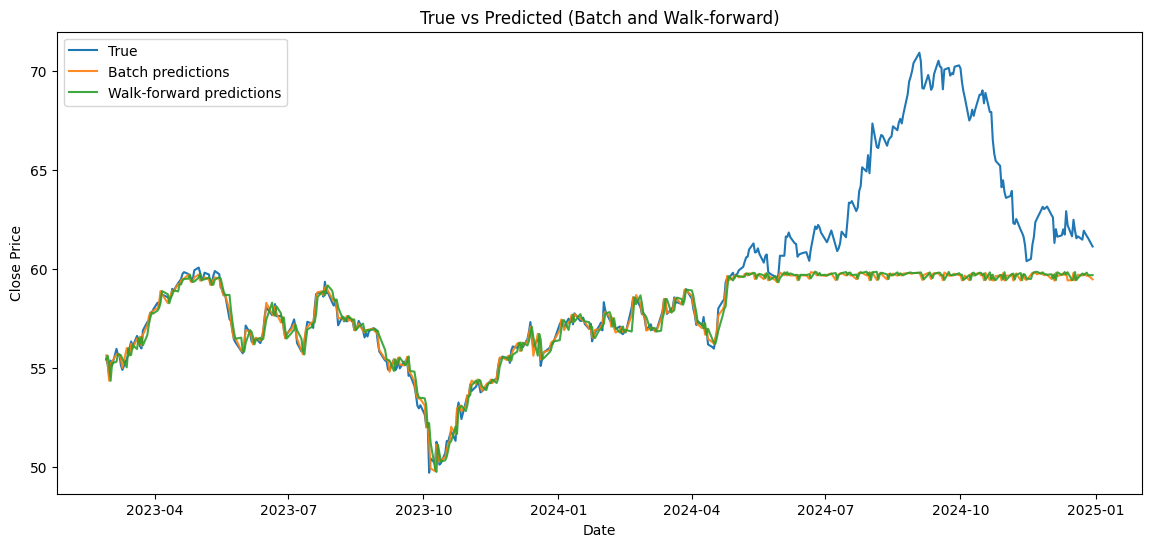

In [47]:
n_lags = 5            # how many lag days to include
test_size = 0.2       # fraction for test
rf_estimators = 300
random_state = 42

# Drop any unwanted columns (e.g., 'Adj Close' or stray 'Price')
for c in ['Adj Close', 'Price']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# Technical indicators: MAs, returns, volatility (we'll shift where appropriate)
df['MA_20'] = df['Close'].rolling(20).mean()
df['MA_50'] = df['Close'].rolling(50).mean()

# Daily return: percentage change (we'll shift so features use past info)
df['Daily_Return'] = df['Close'].pct_change().shift(0)  # keep as same-day return for lagging below

# Volatility: rolling std of returns (shifted by 1 to avoid using future info)
df['Volatility'] = df['Daily_Return'].rolling(20).std().shift(1)

# Create lag features for Close (these are the most important time-series features)
for lag in range(1, n_lags + 1):
    df[f'Close_lag_{lag}'] = df['Close'].shift(lag)
    # Optionally lag other features too, but lags of close are most important

# Drop rows with NA introduced by rolling/lagging
df = df.dropna().copy()

# Define features & target
feature_cols = ['High', 'Low', 'Open', 'Volume', 'MA_20', 'MA_50', 'Daily_Return', 'Volatility'] + \
               [f'Close_lag_{lag}' for lag in range(1, n_lags+1)]
target_col = 'Close'

X = df[feature_cols].astype(float)
y = df[target_col].astype(float)

# Train-test split (time-series: no shuffle)
split_idx = int(len(X) * (1 - test_size))
X_train, X_test = X.iloc[:split_idx].copy(), X.iloc[split_idx:].copy()
y_train, y_test = y.iloc[:split_idx].copy(), y.iloc[split_idx:].copy()

# ---------------------------
# Scaling (fit on train only)
# ---------------------------
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# ---------------------------
# Train RandomForest
# ---------------------------
model = RandomForestRegressor(n_estimators=rf_estimators, n_jobs=-1, random_state=random_state)
model.fit(X_train_scaled, y_train)

# Save scaler & model (optional)
joblib.dump(scaler, 'scaler.joblib')
joblib.dump(model, 'rf_model.joblib')

# ---------------------------
# 1) Static batch predictions (baseline)
# ---------------------------
y_pred_batch = model.predict(X_test_scaled)
rmse_batch = mean_squared_error(y_test, y_pred_batch)
mae_batch = mean_absolute_error(y_test, y_pred_batch)
print("Batch RMSE:", rmse_batch, "MAE:", mae_batch)

# ---------------------------
# 2) Walk-forward (rolling) predictions
#    - Simulate forecasting in production:
#      at each test time-step, build features from the most recent actuals/predictions
# ---------------------------
def walk_forward_forecast(model, scaler, X_train, y_train, X_test, n_lags, feature_cols):
    """
    model: trained model
    scaler: fitted scaler
    X_train: DataFrame (train features)
    X_test: DataFrame (test features, but we'll update lag cols with our preds)
    n_lags: number of lag columns (Close_lag_1 .. Close_lag_n)
    """
    preds = []
    # start_row: last row of training data (as the current "latest known" state)
    last_known = X_train.iloc[-1:].copy()  # DataFrame with one row
    # We will update last_known's lag columns as we roll forward
    last_known_scaled = pd.DataFrame(scaler.transform(last_known), columns=last_known.columns, index=last_known.index)

    # We need the order of lag columns to know where to insert new predicted close
    lag_cols = [f'Close_lag_{lag}' for lag in range(1, n_lags+1)]
    # For each step in test
    for i, idx in enumerate(X_test.index):
        # predict using last_known_scaled
        pred = model.predict(last_known_scaled)[0]
        preds.append(pred)

        # Build new row for next step:
        new_row = last_known.copy()  # copy of previous row (unscaled)
        # shift lag columns: lag_1 gets previous close (which is either actual or previous pred),
        # we simulate that lag_1 = predicted close (next step becomes this)
        # Convert to numeric series
        new_row = new_row.iloc[0]  # series

        # shift existing lag columns forward: lag_n <- lag_{n-1}
        # for example Close_lag_5 = Close_lag_4, ..., Close_lag_2 = Close_lag_1
        for lag in range(n_lags, 1, -1):
            new_row[f'Close_lag_{lag}'] = new_row[f'Close_lag_{lag-1}']
        # put newest predicted close into Close_lag_1
        new_row['Close_lag_1'] = pred

        # Update other non-lag features with values from X_test for the next timestamp,
        # because we have actual High/Low/Open/Volume/MA/etc for that timestamp (we assume these are known at prediction time).
        # Use X_test.loc[idx] actual values for these columns
        for col in [c for c in feature_cols if c not in lag_cols]:
            # Use the actual feature value at this test index (we assume they are known, e.g., intraday)
            new_row[col] = X_test.loc[idx, col]

        # Convert back to DataFrame with same index (the upcoming index)
        last_known = pd.DataFrame([new_row.values], columns=new_row.index, index=[idx])
        # scale for next prediction
        last_known_scaled = pd.DataFrame(scaler.transform(last_known), columns=last_known.columns, index=last_known.index)

    return np.array(preds)

y_pred_roll = walk_forward_forecast(model, scaler, X_train, y_train, X_test, n_lags, feature_cols)
rmse_roll = mean_squared_error(y_test, y_pred_roll)
mae_roll = mean_absolute_error(y_test, y_pred_roll)
print("Walk-forward RMSE:", rmse_roll, "MAE:", mae_roll)

# ---------------------------
# Plot results (true vs batch vs rolling)
# ---------------------------
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='True', linewidth=1.5)
plt.plot(y_test.index, y_pred_batch, label='Batch predictions', alpha=0.9)
plt.plot(y_test.index, y_pred_roll, label='Walk-forward predictions', alpha=0.9)
plt.legend()
plt.title('True vs Predicted (Batch and Walk-forward)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# ---------------------------
# Live prediction helper
# ---------------------------
def predict_live(model, scaler, historical_df, n_lags, feature_cols):
    """
    historical_df: DataFrame of latest historical data already containing the same features as training df
                   (must include Close_lag_* columns built from the last n_lags days)
    Returns predicted next-step Close price.
    """
    # Ensure features exist
    latest = historical_df[feature_cols].iloc[-1:].copy()
    # scale
    latest_scaled = scaler.transform(latest)
    pred = model.predict(latest_scaled)[0]
    return pred

# Example usage for live (you must prepare live_df with same features & lag values)
# live_pred = predict_live(model, scaler, df, n_lags, feature_cols)
# print("Live predicted next Close:", live_pred)
